# Adopted Users Challenge

## Import Relevant Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, classification_report
import timeit
from sklearn.ensemble import RandomForestClassifier

## Import Data

In [2]:
user_info = pd.read_csv('takehome_users.csv', encoding='latin-1')
user_log = pd.read_csv('takehome_user_engagement.csv')

## Explore Raw Data

In [3]:
user_info.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
user_log.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
user_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [6]:
user_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [7]:
user_info.shape

(12000, 10)

In [8]:
user_log.shape

(207917, 3)

## Data Definitions

**user_info**
- name: the user's name
- object_id: the user's id
- email: email address
- creation_source: how their account was created. This takes on one
of 5 values:
- - PERSONAL_PROJECTS: invited to join another user's
personal workspace
- - GUEST_INVITE: invited to an organization as a guest
(limited permissions)
- - ORG_INVITE: invited to an organization (as a full member)
- - SIGNUP: signed up via the website
- - SIGNUP_GOOGLE_AUTH: signed up using Google
Authentication (using a Google email account for their login
id)
- creation_time: when they created their account
- last_session_creation_time: unix timestamp of last login
- opted_in_to_mailing_list: whether they have opted into receiving
marketing emails
- enabled_for_marketing_drip: whether they are on the regular
marketing email drip
- org_id: the organization (group of users) they belong to
- invited_by_user_id: which user invited them to join (if applicable).

**user_log**
- time_stamp: time of login
- user_id: ID of user logging in
- visited: login count

## Data Wrangling

### Drop Columns

In [9]:
# Drop last session creation time column
# Contains 26% null values and info is available in user_log
user_info.drop('last_session_creation_time', axis=1, inplace=True)

### Remove Null Values

In [10]:
# Ensure no 0 user ID
print('In user_info there is a user ID = 0: ', 
      ((user_info['invited_by_user_id'].min() == 0)
       & (user_info['object_id'] == 0)).values.any())
print('In user_log there is a user ID = 0: ', 
      user_log['user_id'].min() == 0)

# Replace NaN values with 0
# Do not want to drop columns
# NaN columns indicate user was not invited
user_info['invited_by_user_id'].fillna(0, inplace=True)

In user_info there is a user ID = 0:  False
In user_log there is a user ID = 0:  False


In [11]:
# Ensure no null values remain in user_info dataframe
print('No null values remain in user_info: ', user_info.notnull().values.any())

# Ensure no null values remain in user_log dataframe
print('No null values remain in user_log: ', user_log.notnull().values.any())

No null values remain in user_info:  True
No null values remain in user_log:  True


### Correct Dtypes

In [12]:
# Convert invited by user id to integer
user_info['invited_by_user_id'] = user_info['invited_by_user_id'].astype('int')

# Convert opted in to mailing list and enabled for marketing drip columns into bools
user_info[['opted_in_to_mailing_list', 'enabled_for_marketing_drip']] = user_info[['opted_in_to_mailing_list', 'enabled_for_marketing_drip']].astype('bool')

# Convert creation time and time stamp columns to datetime objects
user_info['creation_time'] = user_info['creation_time'].astype('datetime64[ns]')
user_log['time_stamp'] = user_log['time_stamp'].astype('datetime64[ns]')

### Check Columns Values

Verify no errors in remaining columns

In [13]:
user_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   opted_in_to_mailing_list    12000 non-null  bool          
 6   enabled_for_marketing_drip  12000 non-null  bool          
 7   org_id                      12000 non-null  int64         
 8   invited_by_user_id          12000 non-null  int64         
dtypes: bool(2), datetime64[ns](1), int64(3), object(3)
memory usage: 679.8+ KB


In [14]:
user_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [15]:
print(user_info['object_id'].min())
print(user_info['object_id'].max())

1
12000


In [16]:
user_info['creation_source'].unique()

array(['GUEST_INVITE', 'ORG_INVITE', 'SIGNUP', 'PERSONAL_PROJECTS',
       'SIGNUP_GOOGLE_AUTH'], dtype=object)

In [17]:
print(user_info['org_id'].min())
print(user_info['org_id'].max())
user_info['object_id'].nunique()

0
416


12000

## Data Wrangling

In [18]:
# Add column for start of week date
user_log['week_start_date'] = user_log['time_stamp'] - pd.to_timedelta(7, unit='d')

# Groupby user_id then week_start_date
# Sum the weekly frequency of visits for each user
# Then reset the index and sort values by week_start_date
user_log = user_log.groupby(['user_id', pd.Grouper(key='week_start_date', freq='W-MON')])\
            ['visited'].sum().reset_index().sort_values('week_start_date')

In [19]:
# Merge user_info and user_log into one dataframe
# Use left join so only user_ids found in user_log are included in merged dataframe
user_merged = pd.merge(left=user_log, right=user_info, 
                       how='left', left_on='user_id', right_on='object_id')
user_merged.drop('object_id', axis=1, inplace=True)

In [20]:
# Add a bool column adopted_user that is 
# true when a user visted the site three or more times in a week
user_merged['adopted_user'] = user_merged['visited'] >= 3

In [21]:
user_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68796 entries, 0 to 68795
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     68796 non-null  int64         
 1   week_start_date             68796 non-null  datetime64[ns]
 2   visited                     68796 non-null  int64         
 3   creation_time               68796 non-null  datetime64[ns]
 4   name                        68796 non-null  object        
 5   email                       68796 non-null  object        
 6   creation_source             68796 non-null  object        
 7   opted_in_to_mailing_list    68796 non-null  bool          
 8   enabled_for_marketing_drip  68796 non-null  bool          
 9   org_id                      68796 non-null  int64         
 10  invited_by_user_id          68796 non-null  int64         
 11  adopted_user                68796 non-null  bool      

## Dummy Columns for Categorical Features

In [22]:
# Create dummy columns for all categorical columns
user_dumb = pd.get_dummies(user_merged, columns=['creation_source'], drop_first=True)

In [23]:
# View resulting dataframe
user_dumb.head()

,user_id,week_start_date,visited,creation_time,name,email,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,6047,2012-05-28,1,2012-06-02 20:33:31,Lawes Victoria,VictoriaLawes@gmail.com,True,True,298,0,False,0,0,0,1
1,2494,2012-05-28,1,2012-06-03 00:58:46,Robinson Christopher,fboqoxyy@wqmog.com,False,False,270,2494,False,1,0,0,0
2,1551,2012-05-28,1,2012-06-02 08:27:26,Gomes Bruna,BrunaCastroGomes@cuvox.de,False,False,226,6434,False,0,0,0,0
3,4584,2012-05-28,1,2012-06-02 06:37:08,Eriksen Helena,HelenaMEriksen@hotmail.com,False,False,102,0,False,0,1,0,0
4,2136,2012-05-28,1,2012-06-02 07:58:51,Freytag Kathrin,KathrinFreytag@hotmail.com,False,True,0,6961,False,0,0,0,0


## Test Train Split

In [24]:
# Set dependent variable to active user column
y = user_dumb['adopted_user']

# Use all remaining columns (besides date columns) as independent variables
X = user_dumb.drop(['user_id', 'week_start_date', 'creation_time', 'name', 'email', 'adopted_user'], axis=1)

In [25]:
# Train test split data, keeping 25% of data for test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Print train and test shapes
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(51597, 9) (51597,)
(17199, 9) (17199,)


## Dependent Variable Class Distribution

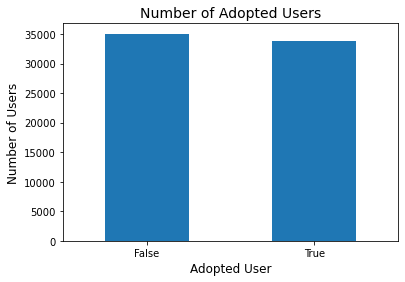

In [26]:
_ = user_merged['adopted_user'].value_counts().plot(kind='bar')
_ = plt.xticks(rotation=0)
_ = plt.title('Number of Adopted Users', fontsize=14)
_ = plt.xlabel('Adopted User', fontsize=12)
_ = plt.ylabel('Number of Users', fontsize=12)

## Modeling

Learning type: Supervised learning
- Data labelled as adopted user or not

Model Type: Binary, classification probelm
- Discrete variables with two types; either adopted or not

Evaluation Metric: accuracy
 - Dependent variable has even class distribution
 
Binary, classification models:
- Support Vector Machines: performs poorly for overlapping classes so will not use in this case
- Naive Bayes: assumes all features are independent and contribute equally so will not use in this case
- K-Nearest Neighbors: more commonly used on small datasets with limited number of features so will not use in this case
- Logistic regression: easily outperformed so will not use in this case
- Decision trees: prone to overfitting and sensitive to data so will not use in this case
- Random forest: useful to extract feature importance which is what we are solving for so will use 
- XGBoost: good at extracting feature importance and less prone to overfitting but harder to tune

**Random forest will be used in this case**
- XGBoost also a model to consider but since requires more attention to tuning will not use in the interest of time

In [27]:
# Use RandomizedSearchCV to find best parameters for Random Forest Model
param_grid_rf = {'n_estimators':[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
                 'criterion':['gini', 'entropy'],
                 'max_depth':[3, 4, 5, 6, 7, 8, 9, 10, 12, 13]}
rf = RandomForestClassifier()
cv = RandomizedSearchCV(rf, param_grid_rf, cv=5) # Split training data into 5 cross validations
cv.fit(X_train, y_train) 
print(cv.best_params_)
print(cv.best_score_)

{'n_estimators': 300, 'max_depth': 5, 'criterion': 'entropy'}
1.0


In [28]:
# Define the best parameters from the outcome of the above RandomizedSearch
best_n_estimators = cv.best_params_['n_estimators']
best_criterion = cv.best_params_['criterion']
best_max_depth = cv.best_params_['max_depth']

# Start time to predict model runtime
start = timeit.default_timer()

# Fit and predict model using best parameter
best = RandomForestClassifier(n_estimators=best_n_estimators, criterion=best_criterion,
                                 max_depth=best_max_depth)
best.fit(X_train, y_train)
y_pred = best.predict(X_test)

# Stop time to predict model runtime
stop = timeit.default_timer()

# Define model runtime variable
time = stop - start

In [29]:
print('Classification Report: Random Forest Classifier Model')
print('')
print(classification_report(y_test, y_pred))

Classification Report: Random Forest Classifier Model

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      8807
        True       1.00      1.00      1.00      8392

    accuracy                           1.00     17199
   macro avg       1.00      1.00      1.00     17199
weighted avg       1.00      1.00      1.00     17199



In [30]:
# Define F1 score
accuracy = make_scorer(accuracy_score)

# Cross-validate model performance
cv_test = cross_val_score(best, X_test, y_test, cv=5, scoring=accuracy)
cv_train = cross_val_score(best, X_train, y_train, cv=5, scoring=accuracy)
print(cv_test)

# Find average of CV scores for test & train
cv_train_avg = cv_train.mean()
cv_train_std = cv_train.std()
cv_test_avg = cv_test.mean()
cv_test_std = cv_test.std()
print('')
print ('Mean cross validation train score: ', cv_train_avg)
print ('Standard deviation in train cv scores: ', cv_train_std)
print('')
print ('Mean cross validation test score: ', cv_test_avg)
print ('Standard deviation in test cv scores: ', cv_test_std)
print('')
print('Runtime: ', time)

[1. 1. 1. 1. 1.]

Mean cross validation train score:  1.0
Standard deviation in train cv scores:  0.0

Mean cross validation test score:  1.0
Standard deviation in test cv scores:  0.0

Runtime:  3.2876471589988796


## Feature Importance

In [31]:
# Rank feature importance
features = X
importances = list(best.feature_importances_)
importances_sorted = np.sort(importances)
importance_table = pd.DataFrame(list(zip(X, importances_sorted)), 
                                columns =['Features', 'Importance scores'],
                                index=[1, 2, 3, 4, 5, 6, 7, 8, 9]) 
importance_table

,Features,Importance scores
1,visited,0.000048
2,opted_in_to_mailing_list,0.000136
3,enabled_for_marketing_drip,0.000249
4,org_id,0.000294
5,invited_by_user_id,0.000329
6,creation_source_ORG_INVITE,0.000459
7,creation_source_PERSONAL_PROJECTS,0.002498
8,creation_source_SIGNUP,0.005124
9,creation_source_SIGNUP_GOOGLE_AUTH,0.990864


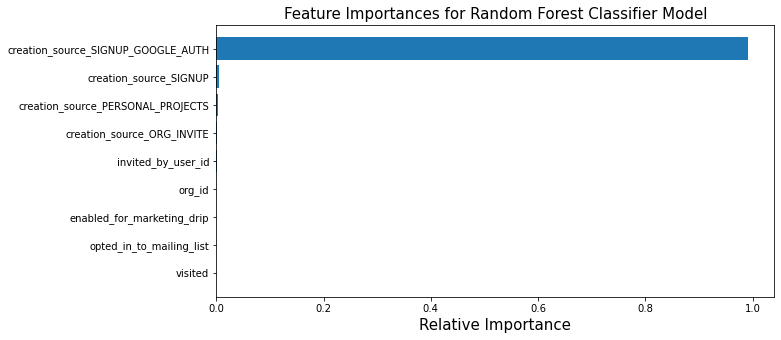

In [32]:
# Bar graph of feature importance
index = [0, 1, 2, 3, 4, 5, 6, 7, 8]
_ = plt.figure(figsize=(10, 5))
_ = plt.barh(index, importances_sorted)
_ = plt.xlabel('Relative Importance', fontsize=15)
_ = plt.yticks(index, features)
_ = plt.title('Feature Importances for Random Forest Classifier Model', fontsize=15)
plt.show()

## Take Aways

Random Forest was able to correctly classify all users. The above model has a cross validation score of 1.0 with a standard deviation of 0. The optimal parameters are 300 trees, a max depth of 5, and entropy for node impurity. Runtime was 3.3. Google authentication creation source was found to be the single most important feature with 99% of the relative importance.